# CS246 - Colab 7
## Decision Trees on Spark

### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u292-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


Now we authenticate a Google Drive client to download the files we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='1aJrdYMVmmnUKYhLTlXtyB0FQ9gYJqCrs'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('mnist-digits-train.txt')

id='1yLwxRaJIyrC03yxqbTKpedMmHEF86AAq'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('mnist-digits-test.txt')

If you executed the cells above, you should be able to see the dataset we will use for this Colab under the "Files" tab on the left panel.

Next, we import some of the common libraries needed for our task.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.

In [5]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [6]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [7]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-09-27 17:07:57--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.19M  36.3MB/s    in 0.4s    

2021-09-27 17:07:58 (36.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   
http://b6fa-35-222-243-56.ngrok.io


### Data Loading

![MNIST](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/220px-MnistExamples.png)

In this Colab, we will be using the famous [MNIST database](https://en.wikipedia.org/wiki/MNIST_database), a large collection of handwritten digits that is widely used for training and testing in the field of machine learning.

For your convenience, the dataset has already been converted to the popular LibSVM format, where each digit is represented as a sparse vector of grayscale pixel values.

In [8]:
training = spark.read.format("libsvm").load("mnist-digits-train.txt")
test = spark.read.format("libsvm").load("mnist-digits-test.txt")

# Cache data for multiple uses
training.cache()
test.cache()

DataFrame[label: double, features: vector]

In [9]:
training.show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
test.show(truncate=False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [11]:
training.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



In [12]:
test.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



### Your task

First of all, find out how many instances we have in our training / test split.

In [13]:
# YOUR CODE HERE
print("Counting instances in training dataset: {}".format(training.count()))
print("Counting instances in test dataset: {}".format(test.count()))

Counting instances in training dataset: 60000
Counting instances in test dataset: 10000


Now train a Decision Tree on the training dataset using Spark MLlib.

You can refer to the Python example on this documentation page: [https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier](https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)

(Note : You **don't** need to and should **NOT** use Indexer as shown by the example, so that your answers can match our solution answers for gradescope problems.)

In [14]:
# YOUR CODE HERE
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Train model
model = dt.fit(training)

# Make predictions.
predictions = model.transform(test)

With the Decision Tree you just induced on the training data, predict the labels of the test set.
Print the predictions for the first 10 digits, and compare them with the labels.

In [15]:
# YOUR CODE HERE
predictions.select("prediction", "label").show(10)

+----------+-----+
|prediction|label|
+----------+-----+
|       7.0|  7.0|
|       6.0|  2.0|
|       8.0|  1.0|
|       0.0|  0.0|
|       9.0|  4.0|
|       1.0|  1.0|
|       5.0|  4.0|
|       9.0|  9.0|
|       6.0|  5.0|
|       9.0|  9.0|
+----------+-----+
only showing top 10 rows



The small sample above looks good, but not great!

Let's dig deeper. Compute the accuracy of our model, using the ```MulticlassClassificationEvaluator``` from MLlib.

In [16]:
# YOUR CODE HERE
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

Test Error = 0.3244 


In [17]:
print("Accuracy = %g " % accuracy)

Accuracy = 0.6756 


Find out the max depth of the trained Decision Tree, and its total number of nodes.

In [18]:
# YOUR CODE HERE

depth_model = model.depth

number_of_nodes = model.numNodes

# summary only
print(depth_model)
print(number_of_nodes)

5
61


It appears that the default settings of the Decision Tree implemented in MLlib did not allow us to train a very powerful model!

Before starting to train a Decision Tree, you can tune the max depth it can reach using the [setMaxDepth()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.DecisionTreeClassifier.html#pyspark.ml.classification.DecisionTreeClassifier.setMaxDepth) method. Train 21 different DTs, varying the max depth from 0 to 20, endpoints included (i.e., [0, 20]). For each value of the parameter, print the accuracy achieved on the test set, and the number of nodes contained in the given DT.

**IMPORTANT:** this parameter sweep can take 30 minutes or more, depending on how busy is your Colab instance. Notice how the induction time grows super-linearly!

In [19]:
# YOUR CODE HERE
def train_model(training_set, max_depth):
  # Train a DecisionTree model.
  dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=max_depth)

  # Train model
  model = dt.fit(training_set)

  # Make predictions.
  predictions = model.transform(test)

  evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
  
  accuracy = evaluator.evaluate(predictions)

  return accuracy

In [20]:
lst_acc = []

for depth in range(0, 10):
  acc = train_model(training, depth)
  lst_acc.append(acc)

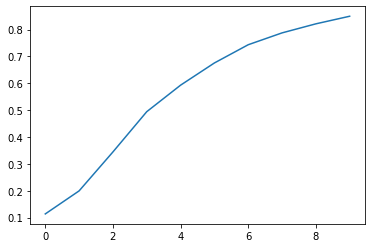

In [21]:
plt.plot(lst_acc)
plt.show()

Once you have working code for each cell above, **head over to Gradescope, read carefully the questions, and submit your solution for this Colab**!